# Data Wrangling - Assignment 1

## 0. Setup

In [121]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
from shutil import rmtree
from typing import Dict, List, Tuple

import numpy as np
import cv2 as cv
import pandas as pd
import requests

from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

%matplotlib inline

## 1. Fetching Data and Preprocessing

If `FETCH_DATA` is set to True, the raw data from previous executions will be deleted. All data is then fetched again from these data sources:


| Data                      | Source                         | URL                                                                                      | Datatype  |
|:---                       |:---                            |:---                                                                                      | :---      |
| Basic Data on Communes    | Bundesamt für Statistik        | https://dam-api.bfs.admin.ch/hub/api/dam/assets/15864450/master                          | XLSX File |
| Coat of Arms of Communes  | Staatsarchiv Kanton Luzern     | https://staatsarchiv.lu.ch/kantonsgeschichte/gemeinden/Gemeindewappen/*\[commune\]*      | JPG Files |
| Points of Interest        | Geoportal Kanton Luzern        | https://public.geo.lu.ch/ogd/rest/services/managed/DIGOPPOI_COL_V1_MP/MapServer/1/query   | JSON File |
| Anzahl Hunde pro Gemeinde | Identitas AG                   | https://tierstatistik.identitas.ch/data/dogs-map-commune.csv                             | CSV File  |

In [4]:
FETCH_DATA = False
RAW_DATA_PATH = Path().cwd() / 'raw_data'
COMMUNES_PATH = RAW_DATA_PATH /  'communes.xlsx'
COAT_OF_ARMS_PATH = RAW_DATA_PATH / 'coat_of_arms'
POI_PATH = RAW_DATA_PATH / 'poi'
DOGS_PATH = RAW_DATA_PATH / "dogs.csv"

In [5]:
def delete_raw_data(raw_data_dir: Path, subdirs: List[Path]) -> None:
    '''
    Deletes all raw data if the raw data directory exists.

    Parameters
    ----------
    raw_data_dir : Path
        The path of the directory that contains the raw data.
    subdirs : List[Path]
        A list of subdirs as an absolute path to create inside the raw data directory.
    '''
    if raw_data_dir.exists():
        rmtree(raw_data_dir)
    
    raw_data_dir.mkdir()

    for dir in subdirs:
        dir.mkdir()

In [6]:
if FETCH_DATA:
    delete_raw_data(RAW_DATA_PATH, [COAT_OF_ARMS_PATH])

### 1.1. Basic Data: XLSX File for Data on all Comunes

#### 1.1.1. Fetch XLSX File

In [7]:
def download_binary_file(url: str, destination_dir: Path) -> None:
    '''
    Downloads a file from a given URL via a HTTP GET request.

    Parameters
    ----------
    url : str
        The URL of the file.
    destination_dir : Path
        The path of directory in which the file should be stored.
    Returns
    -------
    None
    '''
    request = requests.get(url)
    request.raise_for_status()

    with open(destination_dir, "wb") as f:
        f.write(request.content)

In [8]:
if FETCH_DATA:
    bfs_url = 'https://dam-api.bfs.admin.ch/hub/api/dam/assets/15864450/master'
    download_binary_file(bfs_url, destination_dir=COMMUNES_PATH)

#### 1.1.2. Preprocess XLSX File

In [9]:
def preprocess_communes_df(raw_communes: pd.DataFrame, min_bfs_nr: int, max_bfs_nr: int) -> Tuple[pd.DataFrame, Dict[int, str]]:
    '''
    Applies the preprocessing steps to the raw communes DataFrame.

    Parameters
    ----------
    raw_communes : DataFrame
        The raw DataFrame after loading from an excel file.
    min_bfs_nr : int
        The BFS number
        (`see Wikipedia <https://en.wikipedia.org/wiki/Community_Identification_Number#Switzerland>`_)
        of the first commune to include in the preprocssed DataFrame.
    max_bfs_nr : int
        The BFS number of the last commune to include in the preprocessed
        DataFrame (The commune with this number will be included in the
        preprocessed DataFrame).
    
    Returns
    -------
    communes : pd.DataFrame
        The complete preprocessed DataFrame.
    communes_names : dict
        A DataFrame that contains only the names of the communes in the
        the range of BFS numbers passed to this function.
    '''
    
    # Improve column names by removing:
    # - '-' characters to
    # - unecessary references like 1)
    raw_communes.rename(
        columns = {
            raw_communes.columns[3]: raw_communes.columns[3].replace('-', ''),
            raw_communes.columns[14]: raw_communes.columns[14][:-3],
            raw_communes.columns[32]: raw_communes.columns[32][:-3],
        },
        inplace=True
    )

    raw_communes.drop(labels=np.nan, axis=0, inplace=True)
    raw_communes.set_index(raw_communes.index.astype('int'), inplace=True)

    # select communes, that have BFS numbers in the given range
    communes = raw_communes.loc[min_bfs_nr:max_bfs_nr]

    # Remove the LU suffix present for some communes
    communes.loc[:, 'Gemeindename'] = communes.loc[:, "Gemeindename"].str.replace(
        r'(?P<name>\w+) \(LU\)',
        lambda m: m.group('name'),
        regex=True,
    )

    communes_names = communes.loc[:, 'Gemeindename'].sort_values().to_dict()
    return communes, communes_names

In [10]:
communes = pd.read_excel(
    COMMUNES_PATH,
    skiprows=[0, 1, 2, 3, 4, 6, 7],
    skipfooter=16,
    index_col=0,
)

communes_lu, communes_lu_names = preprocess_communes_df(
    raw_communes=communes,
    min_bfs_nr=1001,
    max_bfs_nr=1151,
)

### 1.2. Additional Data: Gemeindewappen 

#### 1.2.1. Fetch JPG Files

In [11]:
def download_coat_of_arms(source_url: str, destination_dir: Path, commune_names: Dict[int, str], logging: bool=False) -> None:
    '''
    Downloads images of all coats of arms from Staatsarchiv Luzern.

    Parameters
    ----------
    source_url : str
        The URL to download the images from.
    destination_dir : Path
        The Path of the directory where the coats of arms should be stored.
    commune_names : dict
        A dict that matches all BFS numbers of the communes to their names.
    logging : bool
        If True, logging messages will be printed. Defaults to False.
    
    Returns
    -------
    None
    '''
    # fetch images of coat of arms for all communes
    for cid, commune in commune_names.items():
        # handle concatenated and multi-word commune names
        if '-' in commune:
            commune = commune.split('-')[0]
        elif ' ' in commune:
            commune = commune.split(' ')[0]
        # The coat of arms of 'Willisau' is stored under 'Willisau-Stadt'
        # in https://staatsarchiv.lu.ch
        elif commune == 'Willisau':
            commune = 'Willisau-Stadt'

        current_url = source_url + commune
        if logging:
            print(f'Fetching {current_url}')
        request = requests.get(current_url)
        request.raise_for_status()

        soup = BeautifulSoup(request.text, 'html.parser')
        img = soup.find(id='maincontent_1_imgImage')
        img_url = 'https://staatsarchiv.lu.ch' + img.get('src')

        img_request = requests.get(img_url)
        img_request.raise_for_status()

        current_img_path = destination_dir / f'{cid}.jpg'
        with open(current_img_path, "wb") as f:
            f.write(img_request.content)

In [12]:
if FETCH_DATA:
    sa_lu_url = 'https://staatsarchiv.lu.ch/kantonsgeschichte/gemeinden/Gemeindewappen/'
    download_coat_of_arms(
        sa_lu_url, COAT_OF_ARMS_PATH,
        communes_lu_names, logging=True
    )

### 1.3. Additional Data: Points of Interest



#### 1.3.1. Fetch Points of Interest

In [13]:
def download_points_of_interest(soruce_url: str, destination_dir: Path) -> None:
    '''
    Downloads a JSON file of all points of interest (POI) from a MapServer using
    a HTTP POST request.

    Parameters
    ----------
    source_url : str
        The URL to download the points of interest from.
    destination_dir : Path
        The Path of the directory where the downloaded data should be stored.
    
    Returns
    -------
    None
    '''

    # API options in post body
    payload = {
        'f': 'pjson', # set output to json
        'outFields': 'BFS_NR,POI_NAME,INFO_URL', # select relevant fields
        'returnGeometry': 'true', # get the coordinates of the POI
        'units': 'esriSRUnit_Meter' #  set the untis to meters
    }

    # Fetch data from ESRI MapServer
    request = requests.post(soruce_url, data=payload)
    request.raise_for_status()

    with open(destination_dir / 'poi.json', 'wt', encoding='utf-8') as f:
        f.write(request.text)

In [14]:
if FETCH_DATA:
    geo_lu_url = 'https://public.geo.lu.ch/ogd/rest/services/managed/DIGOPPOI_COL_V1_MP/MapServer/1/query'
    download_points_of_interest(
        soruce_url=geo_lu_url,
        destination_dir=POI_PATH
    )

### 1.4. Additional Data: Dogs per Commune

#### 1.4.1. Download CSV File

In [77]:
def download_text_file(url: str, destination_dir: Path) -> None:
    '''
    Downloads a text file from the given ``url`` via a HTTP GET request.

    Parameters
    ----------
    url : str
        The URL of the file.
    destination_dir : Path
        The path of directory in which the file should be stored.
    Returns
    -------
    None
    '''
    request = requests.get(url)
    request.raise_for_status()

    with open(destination_dir, "wt") as f:
        f.write(request.text)

In [79]:
if FETCH_DATA:
    dogs_url = 'https://tierstatistik.identitas.ch/data/dogs-map-commune.csv'
    download_text_file(dogs_url, DOGS_PATH)

#### 1.4.2. Preprocess CSV file

In [81]:
def preprocess_dog_df(raw_dogs: pd.DataFrame, commune_names: Dict[int, str]) -> Tuple[pd.DataFrame, Dict[int, str]]:
    '''
    Applies the preprocessing steps to the raw dogs DataFrame.

    Parameters
    ----------
    raw_dogs : DataFrame
        The raw DataFrame after loading from an csv file.
    commune_names : Dict[int, str]
        A dictionary mapping each commune's BFS number to its name.
        Only dog counts for communes included in this dictionary will
        be considered.
    Returns
    -------
    dogs : pd.DataFrame
        The complete preprocessed DataFrame.
    '''
    
    new_dog_df = raw_dogs.rename(
        columns = {
            'commune': 'Gemeindename',
            'countPerSurfacekm2': 'Anzahl Hunde pro km2',
            'countPer100Inhabitants': 'Anzahl Hunde pro 100 Einwohner',
            'count': 'Anzahl Hunde',
        }
    )

    new_dog_df.drop(['top5breeds', 'top5names'], axis=1, inplace=True)

     # Remove the LU suffix present for some communes
    new_dog_df.loc[:, 'Gemeindename'] = new_dog_df.loc[:, "Gemeindename"].str.replace(
        r'(?P<name>\w+) \(LU\)',
        lambda m: m.group('name'),
        regex=True,
    )

    # select only select dog data for communes from the list
    dogs_lu = new_dog_df.loc[new_dog_df.loc[:, 'Gemeindename'].isin(commune_names.values())].copy()
    
    # add BFS number as index
    name2nr = { name : nr for nr, name in commune_names.items() } 
    dogs_lu['Gemeindecode'] = dogs_lu.loc[:, 'Gemeindename'].apply(lambda name : name2nr[name])
    
    dogs_lu.set_index('Gemeindecode', inplace=True, drop=True)
    dogs_lu.sort_values(by='Gemeindecode', inplace=True)

    return dogs_lu

In [144]:
dogs = pd.read_csv(DOGS_PATH, sep=';', skiprows=1)
display(dogs.loc[dogs["commune"] == 'Honau'])

honau_row = pd.DataFrame(
    {'commune': 'Honau',
     'count': 0,
     'countPerSurfacekm2': 0,
     'countPer100Inhabitants': 0,
     'top5breeds':np.nan,
     'top5names': np.nan
    },
    index=[dogs.shape[0]])
dogs = pd.concat([dogs, honau_row])

df_dogs = preprocess_dog_df(dogs, communes_lu_names)

,commune,count,countPerSurfacekm2,countPer100Inhabitants,top5breeds,top5names


As shown above, the commune Honau is not in included in this dataset. The number of dogs is assumed to be 0, because in the dataset from January 2025 the commune was still included and had a count of 0.

## 2. Feature Extraction

Extract the relevant features from all downloaded data sources. 

### 2.1. Extract Relevant Features from communes file

The only a part of the columns in the communes file is used. 

In [145]:
base_data = communes_lu.iloc[:, [0, 1, 3, 5, 6, 7, 14, 15, 17, 19, 29, 30]]
base_data

,Gemeindename,Einwohner,Bevölkerungsdichte pro km²,0-19 Jahre,20-64 Jahre,65 Jahre und mehr,Gesamtfläche in km²,Siedlungsfläche in %,Landwirtschafts-fläche in %,Wald und Gehölze in %,Leerwohnungs-ziffer,Neu gebaute Wohnungen pro 1000 Einwohner
Gemeindecode,,,,,,,,,,,,
1001,Doppleschwand,789,113.525180,26.742712,58.681876,14.575412,6.95,5.755396,55.683453,36.115108,1.704545,1.272265
1002,Entlebuch,3280,57.644991,21.798780,59.664634,18.536585,56.90,3.686151,49.552396,42.829559,1.092896,8.446456
1004,Flühli,1929,17.833041,21.876620,60.290306,17.833074,108.17,2.497918,44.527708,38.236655,1.052150,5.112474
1005,Hasle,1736,43.066237,22.695853,59.907834,17.396313,40.31,3.248202,49.094967,39.573518,2.241594,17.694064
1007,Romoos,659,17.625033,22.003035,59.787557,18.209408,37.39,2.088353,35.796519,60.803213,0.874636,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1145,Ufhusen,888,72.727273,21.959459,60.585586,17.454955,12.21,5.496308,73.256768,20.918786,1.250000,15.503876
1146,Wauwil,2261,763.851351,20.477665,64.838567,14.683768,2.96,21.088435,68.707483,10.204082,4.360465,11.483693
1147,Wikon,1520,183.574879,22.828947,59.210526,17.960526,8.28,9.650181,38.359469,51.869723,0.722543,6.557377


### 2.2. Extract Features from coats of arms

#### Color Red in HSV Color Model:

$H \in [0, 16] = [0, 8]$ in OpenCV $ \land$ $H \in [343,359] = [171, 179]$ in OpenCV

$S \ge 45 \% \approx 115 $ in OpenCV

$V \ge 45 \% \approx 115 $ in OpenCV

#### Color Yellow in HSV Color Model:

$H \in [45, 65] \approx [23, 32]$ in OpenCV

$S \ge 35 \% \approx 90$ in OpenCV

$V \ge 35 \% \approx 90 $ in OpenCV

In [146]:
def count_background_pixels(image: np.ndarray, logging: bool=False) -> int:
    '''
    Count the number of background pixels in ``image`` by:
    - converting the ``image`` to grayscale
    - then applying a threshold found using Otsu's method
    - finally count the number pixels in the connected component
      to which the pixel in the top right corner belongs to.

    Parameters
    ----------
    image : numpy.ndarray
        The image to count the background pixels of.
    logging : bool
        If True, logging messages will be printed. Defaults to False.
    
    Returns
    -------
    bg_count : int
        The number of background pixels.
    '''
    gray_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    found_th, thresh = cv.threshold(gray_img, 0, 255,
                                    cv.THRESH_BINARY+cv.THRESH_OTSU)
    if logging:
        print(f'Threshold found with Otsu Methods: {found_th}')

    nr_of_labels, labels = cv.connectedComponents(thresh)
    if logging:
        print(f'Number of Labels: {nr_of_labels}')

    bg_label = labels[0, 0]
    if logging:
        print(f'Label of background: {bg_label}')

    return labels[labels == bg_label].size



In [147]:
def plot_selected_color_range(image: np.ndarray, selected_px_locations: np.ndarray) -> None:
    '''
    Plots a comparison between the original image and the selected
    color range.

    Parameters
    ----------
    image : numpy.ndarray
        The original image.
    selected_px_locations : numpy.ndarray
        An numpy.ndarray in which the pixels that belong to a color range
        are set to 255, while all other pixels are 0.

    Returns
    -------
    None
    '''
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(selected_px_locations, cmap='gray')
    axes[0].set_title('Extracted Parts')
    axes[1].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    axes[1].set_title('Original')

    for ax in axes:
        ax.set_axis_off()
    plt.show()

In [149]:
def calculate_color_ratio(image_path: Path, color_range1: Tuple[np.array, np.array],
                          color_range2: Tuple[np.array, np.array] | None = None,
                          plot_image: bool = False) -> float:
    '''
    Calculates which ratio of pixels in an image fall in one or two
    specified color ranges.

    Parameters
    ----------
    image_path : Path
        The path to the image file.
    color_range1 : Tuple
        A tuple containing two arrays that define the lower and upper bounds
        of the first color range in the HSV color space.
    color_range2 : Tuple | None
        An optional tuple for a second color range. Its format is the same
        as for ``color_range1``.
    plot_image : bool
        If True, the image and the selected colors will be plotted.
        Defaults to False.
    
    Returns
    -------
    color_ratio : float
        The ratio of pixels in the image that fall within the specified
        color range(s).
    '''
    img = cv.imread(image_path)
    if img is None:
        raise ValueError('Failed to load image using the given Path.')

    # Convert image to HSV color model
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # locations of the pixels inside the given range
    locations_range1 = cv.inRange(hsv_img, color_range1[0], color_range1[1])
    color_px_locations = locations_range1

    if color_range2:
        locations_range2 = cv.inRange(hsv_img, color_range2[0], color_range2[1])
        color_px_locations = cv.bitwise_or(locations_range1, locations_range2)

    bg_count = count_background_pixels(img)
    if plot_image:
        print(f'Number of background pixels: {bg_count}')
        plot_selected_color_range(img, color_px_locations)

    color_px_count = np.count_nonzero(color_px_locations)
    color_px_ratio = color_px_count / (color_px_locations.size - bg_count)
    return color_px_ratio

In [150]:
# red hue in HSV color model
red_start = ( np.array([0, 115, 115]), np.array([8, 255, 255]) )
red_end = ( np.array([171, 115, 115]), np.array([179, 255, 255]) )

# yellow hue in HSV color model
yellow_start = ( np.array([23, 90, 90]), np.array([32, 255, 255]) )

imgs = sorted(list(COAT_OF_ARMS_PATH.glob('*.jpg')))

color_ratios_red = {
    img_path.stem: calculate_color_ratio(img_path, red_start, red_end)
    for img_path in imgs
}
color_ratios_yellow = {
    img_path.stem: calculate_color_ratio(img_path, yellow_start)
    for img_path in imgs
}

df_color_ratio = pd.DataFrame({'Gemeindecode': color_ratios_red.keys(),
                             'Rotanteil Wappen': color_ratios_red.values(),
                             'Gelbanteil Wappen': color_ratios_yellow.values(),
                             })
df_color_ratio.set_index('Gemeindecode', inplace=True)

df_color_ratio.index = df_color_ratio.index.astype("int")

Number of background pixels: 19742


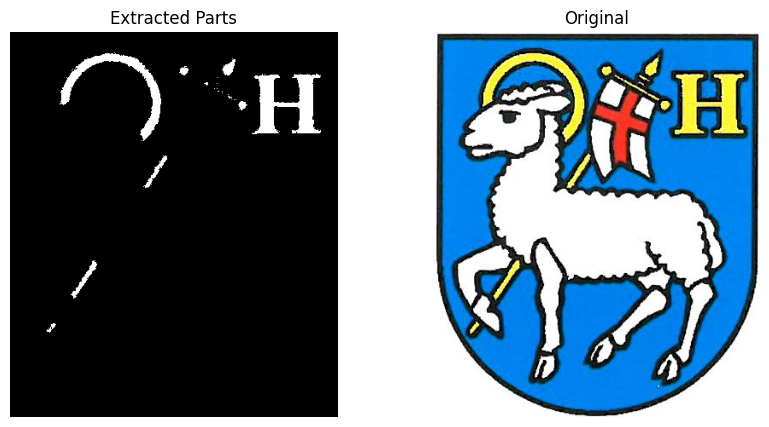

In [151]:
_ = calculate_color_ratio("./raw_data/coat_of_arms/1132.jpg",
                      yellow_start,
                      plot_image=True)

### 2.3. Get Dogs per Inhabitant

In [152]:
dogs_per_area = df_dogs.loc[:, ["Anzahl Hunde pro 100 Einwohner"]]

### 2.4. Merge all DataFrames

In [156]:
lu_data = base_data.join(df_color_ratio, on='Gemeindecode', how='left')
lu_data = lu_data.join(dogs_per_area, on='Gemeindecode', how='left')

lu_data
lu_data.loc[lu_data.Gemeindename.isin(['Entlebuch', 'Romoos', 'Hasle', 'Hergiswil bei Willisau'])]

,Gemeindename,Einwohner,Bevölkerungsdichte pro km²,0-19 Jahre,20-64 Jahre,65 Jahre und mehr,Gesamtfläche in km²,Siedlungsfläche in %,Landwirtschafts-fläche in %,Wald und Gehölze in %,Leerwohnungs-ziffer,Neu gebaute Wohnungen pro 1000 Einwohner,Rotanteil Wappen,Gelbanteil Wappen,Anzahl Hunde pro 100 Einwohner
Gemeindecode,,,,,,,,,,,,,,,
1002,Entlebuch,3280,57.644991,21.798780,59.664634,18.536585,56.90,3.686151,49.552396,42.829559,1.092896,8.446456,0.651710,0.000000,10.0
1005,Hasle,1736,43.066237,22.695853,59.907834,17.396313,40.31,3.248202,49.094967,39.573518,2.241594,17.694064,0.000000,0.000000,9.2
1007,Romoos,659,17.625033,22.003035,59.787557,18.209408,37.39,2.088353,35.796519,60.803213,0.874636,0.000000,0.299652,0.444844,19.6
1132,Hergiswil bei Willisau,1905,60.784939,24.199475,58.320210,17.480315,31.34,4.626675,58.200383,36.407147,1.591187,1.572327,0.011910,0.036574,12.9


## 3. Create Ranking

In [157]:
def rank_normalized(values_to_rank: pd.Series, less_is_better: bool = False) -> pd.Series:
    '''
    Ranks a ``pd.Series`` by scaling its values in a range from 0 to 100 points.

    Parameters
    ----------
    values_to_rank : pd.Series
        The values to rank.
    less_is_better : bool, default
        Inverts the ranking when set to ``True``, so that the lowest value
        gets 100 points.
    
    Returns
    -------
    pd.Series
        A pandas Series containing the ranking for each input value. 
    '''
    value_range = values_to_rank.max() - values_to_rank.min()
    scaled_value = (values_to_rank - values_to_rank.min()) / value_range

    if less_is_better:
        scaled_value = 1 - scaled_value

    return (scaled_value * 100).round().astype('int')

def rank_custom(values_to_rank: pd.Series, winning_range: Tuple[float, float]) -> pd.Series:
    '''
    Ranks a ``pd.Series`` using a custom winning range and losing range. 
    
    Parameters
    ----------
    values_to_rank : pd.Series
        The values to rank.
    winning_range :  Tuple[float, float]
        Values which lie in the ``winning_range`` receive 100 points.
        Other values receive points based on their distance to the winning
        range. Both the lower and the upper bound are included in the range.

    Returns
    -------
    pd.Series
        A pandas Series containing the ranking for each input value. 
    '''

    ranking = values_to_rank.copy()

    # values in the winning range
    win_mask = values_to_rank.loc[(values_to_rank >= winning_range[0]) & (values_to_rank <= winning_range[1])].index
    ranking.loc[win_mask] = 100

    # values samller then the winning range
    low_mask = values_to_rank.loc[values_to_rank < winning_range[0]].index
    ranking.loc[low_mask] = 100 * (values_to_rank[low_mask]) / (winning_range[0])

    # values larger then the winning range
    high_mask = values_to_rank.loc[values_to_rank > winning_range[1]].index
    ranking.loc[high_mask] = 100 * (1 - values_to_rank[high_mask]) / (1 - winning_range[1])
    
    return ranking.astype('int')

In [158]:
values = pd.Series([0.65, 0.125, 1, .5])
rank_custom(values, (0.25, 0.3))

v2 = pd.Series([0, 1, 0.225, 0.775])
rank_custom(v2, (0.45, 0.55))

0     0
1     0
2    50
3    50
dtype: int64

In [164]:
lu_ranked = lu_data.loc[:, ['Gemeindename']].copy()

lu_ranked['Punkte Waldanteil'] = lu_data.loc[:, 'Wald und Gehölze in %'].apply(
    rank_normalized,
    by_row=False)
#lu_ranked['Punkte Bevölkerungsdichte'] = lu_data.loc[:, 'Bevölkerungsdichte pro km²'].apply(
    #rank_normalized,
    #by_row=False, args=(True,))
lu_ranked['Punkte Neue Wohnungen'] = lu_data.loc[:, 'Neu gebaute Wohnungen pro 1000 Einwohner'].apply(
    rank_normalized,
    by_row=False, args=(True,))
lu_ranked['Punkte Rotanteil Wappen'] = lu_data.loc[:, 'Rotanteil Wappen'].apply(
    rank_custom,
    by_row=False, args=((0.25, 0.3),))
lu_ranked['Punkte Gelbanteil Wappen'] = lu_data.loc[:, 'Gelbanteil Wappen'].apply(
    rank_custom,
    by_row=False, args=((0.45, 0.55),))
lu_ranked['Punkte Anzahl Hunde pro Einwohner'] = lu_data.loc[:, 'Anzahl Hunde pro 100 Einwohner'].apply(
    rank_normalized,
    by_row=False)


lu_ranked['Gesamtpunkte'] = lu_ranked.iloc[:, 1:].apply(lambda row: row.mean(), axis=1)
lu_ranked.sort_values(by='Gesamtpunkte', ascending=False, inplace=True)
lu_ranked['Rang'] = np.arange(1, lu_ranked.shape[0] + 1)
lu_ranked.to_csv('ranks.csv')